Finding effective transformation for data augmentation

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import math
import seaborn as sns

import torch
import sys
# sys.path.append('path/to/advchain')
sys.path.append('/vol/biomedic3/cc215/Project/advchain')

from advchain.augmentor.adv_bias import AdvBias
from advchain.augmentor.adv_morph import AdvMorph
from advchain.augmentor.adv_noise import AdvNoise
from advchain.augmentor.adv_affine import AdvAffine
from advchain.augmentor.adv_compose_solver import ComposeAdversarialTransformSolver

from advchain.common.utils import random_chain,load_image_label
from advchain.common.loss import cross_entropy_2D
from advchain.common.utils import _disable_tracking_bn_stats,set_grad
from advchain.models.unet import get_unet_model
from advchain.common.vis import plot_warped_grid, plot_noise,plot_bias_field,plot_image,plot_general

%matplotlib inline
sns.set()


In [7]:

torch.cuda.empty_cache()
print(torch.cuda.current_device())
torch.cuda.set_device(1)
print(torch.cuda.current_device())



1
1


1.1 Load data

In [8]:
def load_image_label(image_path,label_path,slice_id=0, crop_size=(192,192)):

    image = sitk.GetArrayFromImage(sitk.ReadImage(image_path))[slice_id]
    label = sitk.GetArrayFromImage(sitk.ReadImage(label_path))[slice_id]

    print ('image size:',image.shape)
    print ('label size:',label.shape)
    h_diff = (image.shape[0]-crop_size[0])//2
    w_diff = (image.shape[1]-crop_size[1])//2

    cropped_image = image[h_diff:crop_size[0]+h_diff,w_diff:crop_size[1]+w_diff]
    cropped_label = label[h_diff:crop_size[0]+h_diff,w_diff:crop_size[1]+w_diff]

    # rescale image intensities to 0-1
    cropped_image = (cropped_image-cropped_image.min())/(cropped_image.max()-cropped_image.min()+1e-10)
    return cropped_image,cropped_label

## prostate dataset:
image_path ='./data/prostate/img.nrrd'
label_path ='./data/prostate/seg.nrrd'
slice_id = 5
crop_size=(224,224)
cropped_image,cropped_label =load_image_label (image_path,label_path,slice_id=slice_id,crop_size=crop_size)




image size: (307, 307)
label size: (307, 307)


1.2 Preprocessing data

(-0.5, 223.5, 223.5, -0.5)

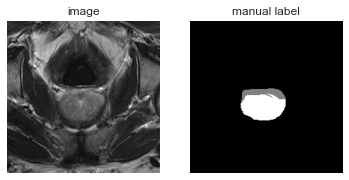

In [9]:
font_size=12
plt.subplot(121)
plt.title('image',size=font_size)
plt.imshow(cropped_image,cmap='gray')
plt.axis('off')

plt.subplot(122)
plt.imshow(cropped_label,cmap='gray')
plt.title('manual label',size=font_size)
plt.axis('off')


2 Load a segmentation model

In [10]:
use_gpu=True
model = get_unet_model(num_classes=3,model_path='./saved_checkpoints/prostate_seg_unet_16.pth',model_arch='UNet_16')

if use_gpu: model = model.cuda()
model.eval()

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(32

image size: (307, 307)
label size: (307, 307)


(-0.5, 223.5, 223.5, -0.5)

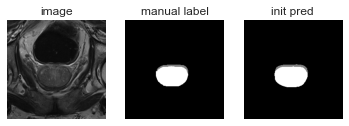

In [11]:
cropped_image,cropped_label =load_image_label(image_path,label_path,slice_id=8,crop_size=crop_size)
font_size=12
image_tensor = torch.from_numpy(cropped_image[np.newaxis,np.newaxis,:,:]).float()
label_tensor = torch.from_numpy(cropped_image[np.newaxis,:,:]).long()
if use_gpu: 
    image_tensor = image_tensor.cuda()
    label_tensor = label_tensor.cuda()
image_tensor.requires_grad=False
init_output = model(image_tensor)
pred_map = init_output.max(1)[1].cpu().data.numpy()

plt.subplot(131)
plt.title('image',size=font_size)
plt.imshow(cropped_image,cmap='gray')
plt.axis('off')
plt.subplot(132)
plt.imshow(cropped_label,cmap='gray')
plt.title('manual label',size=font_size)
plt.axis('off')
plt.subplot(133)
plt.imshow(pred_map[0],cmap='gray')
plt.title('init pred',size=font_size)
plt.axis('off')

3.1 Set up basic transformations

In [12]:
bs=1
im_ch=1
augmentor_bias= AdvBias(
                 config_dict={'epsilon':0.3,
                 'control_point_spacing':[crop_size[0]//2,crop_size[1]//2],
                 'downscale':2,
                 'data_size':(bs,im_ch,crop_size[0],crop_size[1]),
                 'interpolation_order':3,
                 'init_mode':'random',
                 'space':'log'},debug=False)

                 

augmentor_noise= AdvNoise( config_dict={'epsilon':1,
                'xi':1e-6,
                 'data_size':(bs,im_ch,crop_size[0],crop_size[1])},
                 debug=False)
    
augmentor_affine= AdvAffine( config_dict={
                 'rot':15/180,
                 'scale_x':0.2,
                 'scale_y':0.2,
                 'shift_x':0.1,
                 'shift_y':0.1,
                 'data_size':(bs,im_ch,crop_size[0],crop_size[1]),
                 'forward_interp':'bilinear',
                 'backward_interp':'bilinear'},
                 debug=False)

augmentor_morph= AdvMorph(
                config_dict=
                {'epsilon':1.5,
                 'data_size':(bs,im_ch,crop_size[0],crop_size[1]),
                 'vector_size':[crop_size[0]//8,crop_size[1]//8],
                 'interpolator_mode':'bilinear'
                 }, 
                 debug=False)



  


3.2. Set up a solver for adversarial data augmentation

In [13]:
## keep model fixed, set up a solver
model.eval()
transformation_chain = [augmentor_affine,augmentor_noise,augmentor_bias,augmentor_morph]
solver = ComposeAdversarialTransformSolver(
        chain_of_transforms=transformation_chain,
        divergence_types = ['mse','contour'], ### you can also change it to 'kl'.
        divergence_weights=[1.0,0.5],
        use_gpu= True,
        debug=True,
        if_norm_image=False
       )

4.1. Start learning

In [14]:
# random initialization
solver.init_random_transformation()
rand_transformed_image = solver.forward(image_tensor.detach().clone())
rand_predict = model.forward(rand_transformed_image)
warp_back_rand_predict= solver.predict_backward(rand_predict)

rand_bias = augmentor_bias.bias_field
rand_noise = augmentor_noise.param
rand_dxy,rand_morph = augmentor_morph.get_deformation_displacement_field(-augmentor_morph.param)

loss = solver.adversarial_training(
        data=image_tensor,model=model,
        n_iter=1,
        lazy_load=[True]*4, ## if set to true, it will use the previous sampled random bias field as initialization.
        optimize_flags=[True,True,True,True],power_iteration=False)

adv_bias= augmentor_bias.bias_field
adv_noise = augmentor_noise.param
adv_dxy,adv_morph = augmentor_morph.get_deformation_displacement_field(-augmentor_morph.param)
adv_transformed_image = solver.forward(image_tensor.detach().clone())
adv_predict = model.forward(adv_transformed_image)
warp_back_adv_predict= solver.predict_backward(adv_predict)



[inner loop], step 0: dist 0.02055220864713192
update affine parameters
update noise parameters
update bias parameters
update morph parameters
[outer loop] loss 0.07337403297424316


4.2. Visualization

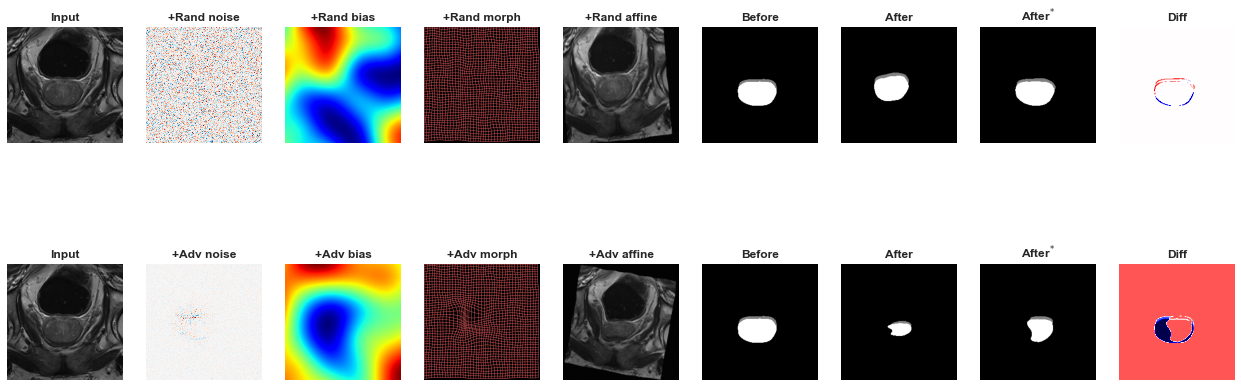

In [15]:
sns.set(font_scale=10)
rand_transformed_image_numpy=rand_transformed_image.cpu().data.numpy()[0,0]
adv_transformed_image_numpy=adv_transformed_image.cpu().data.numpy()[0,0]

rand_predict_numpy=warp_back_rand_predict.max(1)[1].cpu().data.numpy()[0]
adv_predict_numpy=warp_back_adv_predict.max(1)[1].cpu().data.numpy()[0]

rand_before_warped_predict_numpy=rand_predict.max(1)[1].cpu().data.numpy()[0]
adv_before_warped_predict_numpy=adv_predict.max(1)[1].cpu().data.numpy()[0]

rand_bias_numpy=rand_bias.cpu().data.numpy()[0,0]
adv_bias_numpy=adv_bias.cpu().data.numpy()[0,0]

rand_noise_numpy=rand_noise.cpu().data.numpy()[0,0]
adv_noise_numpy=adv_noise.cpu().data.numpy()[0,0]

rand_morph_grid = rand_morph.permute(0,3,1,2)[0].data.cpu().numpy()
adv_morph_grid = adv_morph.permute(0,3,1,2)[0].data.cpu().numpy()
rand_deformed_image =augmentor_morph.transform(image_tensor,rand_dxy).cpu().data.numpy()[0,0]
adv_deformed_image =augmentor_morph.transform(image_tensor,adv_dxy).cpu().data.numpy()[0,0]

gird_interval = 5
vis_deforme_image=False ## turn it on to see deformed image
fig,axes = plt.subplots(2,9,figsize=(22,8))
plot_image(cropped_image,ax = axes[0,0],title='Input',font_size=font_size)
plot_noise(rand_noise_numpy,ax = axes[0,1],title='+Rand noise',font_size=font_size)
plot_bias_field(rand_bias_numpy,ax= axes[0,2],title='+Rand bias')
plot_warped_grid(rand_morph_grid, ax=axes[0,3],bg_img=rand_deformed_image*vis_deforme_image, interval=gird_interval, title="+Rand morph", fontsize=font_size, linewidth=0.5,show=True)
plot_image(rand_transformed_image_numpy, ax=axes[0,4],title="+Rand affine", font_size=font_size)
plot_image(pred_map[0],ax = axes[0,5],title='Before',font_size=font_size)
plot_image(rand_before_warped_predict_numpy,ax = axes[0,6],title='After',font_size=font_size)
plot_image(rand_predict_numpy,ax = axes[0,7],title='After${}^{*}$',font_size=font_size)
plot_general(rand_predict_numpy-pred_map[0],ax = axes[0,8],title='Diff',font_size=font_size,cmap='seismic')

plot_image(cropped_image,title='Input',ax = axes[1,0],font_size=font_size)
plot_noise(adv_noise_numpy,ax = axes[1,1],title='+Adv noise',font_size=font_size)
plot_bias_field(adv_bias_numpy,ax= axes[1,2],title='+Adv bias')
plot_warped_grid(adv_morph_grid, ax=axes[1,3],bg_img=adv_deformed_image*vis_deforme_image, interval=gird_interval, title="+Adv morph", fontsize=font_size, linewidth=0.5,show=True)
plot_image(adv_transformed_image_numpy, ax=axes[1,4],title="+Adv affine", font_size=font_size)
plot_image(pred_map[0],title='Before',ax = axes[1,5],font_size=font_size)
plot_image(adv_before_warped_predict_numpy,ax = axes[1,6],title='After',font_size=font_size)
plot_image(adv_predict_numpy,title='After${}^{*}$',ax = axes[1,7],font_size=font_size)
plot_general(adv_predict_numpy-pred_map[0],ax = axes[1,8],title='Diff',font_size=font_size,cmap='seismic')
plt.savefig('./test_chain_image.png')


5. Example: plug-in adversarial training code to enhance prostate segmentation network training

In [16]:
## now you can simply learn effective adversarial transformation on-the-fly to enhance training. a sample code will be like the following
## pseudo code for model optimization at one iteration: 

## sample a chain
step_sizes = [1,1,1,1]
transformation_family = [augmentor_affine,augmentor_noise,augmentor_bias,augmentor_morph]

[one_chain,one_step_sizes]  = random_chain(transformation_family,step_sizes)

print ('sample a chain:')
[ print ('-> '+tr.get_name()) for tr in one_chain]

solver = ComposeAdversarialTransformSolver(
        chain_of_transforms=one_chain,
        divergence_types = ['mse','contour'], ### you can also change it to 'mse' for mean squared error loss
        divergence_weights=[1.0,0.5],
        use_gpu= True,
        debug=True, ## turn off debugging information when training your model
       )

## compute consistency loss
reg_loss = solver.adversarial_training(
        data=image_tensor,model=model, init_output=init_output.detach().clone(),
        n_iter=1,
        lazy_load=[False]*len(one_chain), 
        optimize_flags=[True]*len(one_chain),  ## you can also turn off adversarial training for one particular transformation
        step_sizes = one_step_sizes)

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
optimizer.zero_grad(set_to_none=True)
model.train()
model.zero_grad()
init_output = model(image_tensor)

## compute supervised loss
supervised_loss = cross_entropy_2D (init_output,label_tensor)
lamda=1
total_loss =supervised_loss+lamda*reg_loss
total_loss.backward()
optimizer.step() 


sample a chain:
-> noise
-> bias
-> morph
-> affine
[inner loop], step 0: dist 0.03536391258239746
update noise parameters
update bias parameters
update morph parameters
update affine parameters
[outer loop] loss 0.1451440453529358


In [17]:
torch.cuda.empty_cache()
